<a href="https://colab.research.google.com/github/Mansouraran/AI-projects/blob/main/Prac_fara_CV_face_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Men-Women Detection

In [ ]:
import os
import shutil, pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers

## 1- Dataset Preparation

### 1-1 Download Dataset from Kaggle

In [ ]:
# the json file downloaded from kaggle needs to choose
from google.colab import files
_ = files.upload() # _ means a temporary variable that prevents to show details because of security

Saving kaggle.json to kaggle.json


In [ ]:
# here should build a directory
!mkdir ~/.kaggle                  # if you had this folder before maybe you are faced with the message below after running
!cp kaggle.json ~/.kaggle/        # copy this file to this directory
!chmod 600 ~/.kaggle/kaggle.json  # it means, this user just have access to this file

In [ ]:
!kaggle datasets download -d saadpd/menwomen-classification

Dataset URL: https://www.kaggle.com/datasets/saadpd/menwomen-classification
License(s): copyright-authors
100% 804M/806M [00:41<00:00, 22.5MB/s]
100% 806M/806M [00:41<00:00, 20.5MB/s]


In [ ]:
# extend the zip fie
!unzip -qq menwomen-classification.zip

### 1-2 Dataset Evaluation

In [ ]:
num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))
num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print(f'Train: Men: {num_men_train} | Women: {num_women_train}')
print(f'Test: Men: {num_men_test} | Women: {num_women_test}')
# Be careful that this dataset is not good for our task we need to prepar these


Train: Men: 1000 | Women: 1912
Test: Men: 418 | Women: 915


### 1-3 Prepar Data Directories

In [ ]:
new_base_dir = pathlib.Path("men_vs_women_small")                   #build a folder with the name("men_vs_women_small")

def make_subset(base_dir, subset_name, start_index, end_index):     # create a method to build a folder with subfolders("men, women")
  for category in ('men', 'women'):
    dir = new_base_dir / subset_name / category                     # path the folder that we created
    if not os.path.exists(dir):                                     # if there is no folder or folders
      os.makedirs(dir)                                              # it creats now all folders
    files = os.listdir(os.path.join(base_dir, category))
    fnames = [files[i] for i in range(start_index, end_index)]       # shuffle how many images that you want to transfer to this folder
    for fname in fnames:
      shutil.copyfile(src=os.path.join(base_dir, category, fname),
                      dst=os.path.join(dir, fname))


In [ ]:
# Copy the number of images related to each folder
make_subset('traindata/traindata', 'validation', start_index=0, end_index=200)
make_subset('traindata/traindata', 'train', start_index=200, end_index=999)
make_subset('testdata/testdata', 'test', start_index=0, end_index=400)


### 1-4 Load Dataset

In [ ]:
print('Train_loder:')                  # display this related to train_folder
train_dataset = image_dataset_from_directory(
    'men_vs_women_small/train',        # name of dataset
    image_size=(180, 180),             # images in difrent size ahould resize to (180, 180)
    batch_size=32,                     # numbers of images enterance
    label_mode='binary'                # we have 2 class(men, women) needs to use binary that Man is 0 and Woman is 1
    )

print('Validation_loder:')             # display this related to validation_folder
validation_dataset = image_dataset_from_directory(
    'men_vs_women_small/validation',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
    )

print('Test_loder:')                   # display this related to test_folder
test_dataset = image_dataset_from_directory(
    'men_vs_women_small/test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
    )

Train_loder:
Found 1598 files belonging to 2 classes.
Validation_loder:
Found 400 files belonging to 2 classes.
Test_loder:
Found 800 files belonging to 2 classes.


In [ ]:
# Display shape of data_batch and label_batch
for data_batch, label_batch in train_dataset:
  print('data batch shape:', data_batch.shape)
  print('label batch shape:', label_batch.shape)

  # Show five random examples of the loaded batch
  fig, axes = plt.subplots(1, 5, figsize=(10, 3))
  for i, ax in enumerate(axes):
    ax.imshow(data_batch[i].numpy().astype('uint8'))
    ax.set_axis_off()
    ax.set_title('Man' if label_batch[i].numpy()==0 else 'Woman')
  break

plt.show()

data batch shape: (32, 180, 180, 3)
label batch shape: (32, 1)


## Model Design

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)      # Normalize images in range between 0 and 1
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# display features map
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

### Configuring the model for training

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 437ms/step - accuracy: 0.4864 - loss: 0.7033 - val_accuracy: 0.5050 - val_loss: 0.7152
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 284ms/step - accuracy: 0.4860 - loss: 0.6974 - val_accuracy: 0.5975 - val_loss: 0.6785
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step - accuracy: 0.5048 - loss: 0.6972 - val_accuracy: 0.5700 - val_loss: 0.6725
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - accuracy: 0.5626 - loss: 0.6881 - val_accuracy: 0.5500 - val_loss: 0.6754
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - accuracy: 0.5720 - loss: 0.6698 - val_accuracy: 0.5475 - val_loss: 0.6822
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 304ms/step - accuracy: 0.5672 - loss: 0.6715 - val_accuracy: 0.5725 - val_loss: 0.6650
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 293ms/step - accuracy: 0.5996 - loss: 0.6663 - val_accuracy: 0.6125 - val_loss: 0.6629
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.6361 - loss: 0.6542 - val_accu

### Displaying curves of loss and accuracy during training

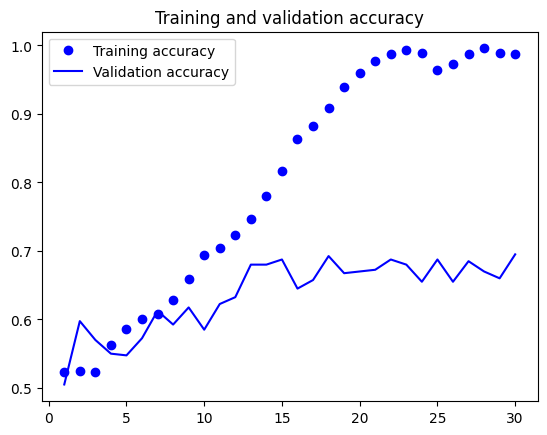

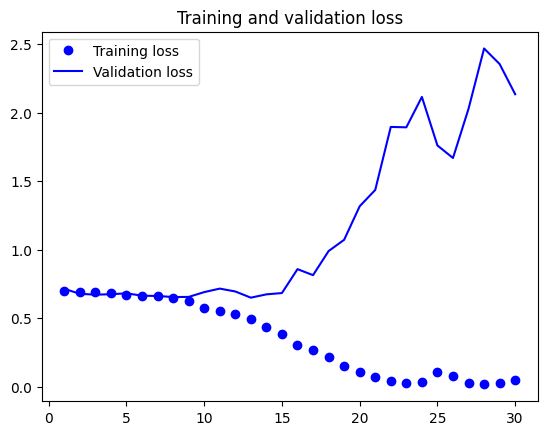

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

##### Pay attention to plots above: here is OVERFITTING




##________________________________________________________-________________________________________________________________

### Evaluating the model on the test set


In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.7917 - loss: 0.4602
Test accuracy: 0.764
